In [2]:
!git clone https://github.com/keras-team/keras-tuner

!pip install keras-tuner/

Cloning into 'keras-tuner'...
remote: Enumerating objects: 9072, done.
remote: Counting objects: 100% (579/579), done.
remote: Compressing objects: 100% (218/218), done.
remote: Total 9072 (delta 450), reused 407 (delta 361), pack-reused 8493
Receiving objects: 100% (9072/9072), 2.13 MiB | 3.61 MiB/s, done.
Resolving deltas: 100% (6470/6470), done.
Processing ./keras-tuner
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 13.1 MB/s eta 0:00:00
  Created wheel for keras-tuner: filename=keras_tuner-1.4.3-py3-none-any.whl size=182858 sha256=c0ae1bcc9fe137911339859c9ff06150099b8e15eda8d166b753c05b00c5f1ec
  Stored in directory: /root/.cache/pip/wheels/6a/f2/f6/4d216b7ba0b7c0374eb8c129c16da679bd15329b761cbad121
Successfully built keras-tuner


In [3]:
!pip install surprise


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3156233 sha256=ced873509505cf98c1849e439b3c79b7b163b297dedbbfd3a50ef15098f97ee0
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


# Recommendation System for E-Commerce

This project creates a popularity-based recommendation system for new customers, a collaborative filtering system for returning customers based on their purchase history and other user ratings, a foundational system for businesses newly setting up their e-commerce platform, and trains a base recommendation model. The project aims to enhance the shopping experience, facilitating increased customer acquisition and retention by offering targeted recommendations throughout the customer's journey.

In [24]:
# Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

plt.style.use("ggplot")

#for embeddings
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Embedding, Dot, Flatten, Dense, Input, concatenate
from tensorflow.keras.optimizers import Adam
from kerastuner import HyperModel, RandomSearch
import shutil

# for collaborative filtering
from surprise import Dataset, Reader, KNNBasic, accuracy
from surprise.model_selection import train_test_split


## Recommendation System

Below we create a recommendation system for new customers that uses product popularity to drive recommendations.

In [5]:
# Popularity-based Recommendation System for New Customers

def popular_products_recommendation(data, top_n=10):

    # Counting the number of ratings each product has received
    popular_products = data.groupby('ProductId')['Rating'].count()

    # Sorting products by the number of ratings
    most_popular = popular_products.sort_values(ascending=False)

    # Return top_n products
    return most_popular.head(top_n)


The code above returns the top n products based on their popularity (number of ratings).

In [6]:
# Loading the dataset
amazon_ratings = pd.read_csv('./ratings_Beauty.csv').dropna()

In [7]:
# Getting the most popular products
top_products = popular_products_recommendation(amazon_ratings, 30)

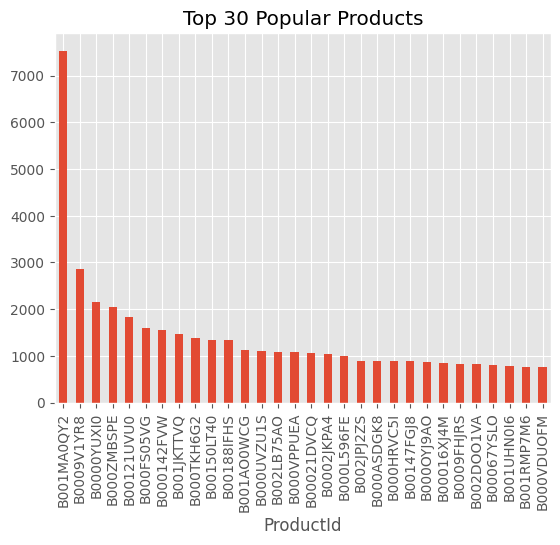

In [8]:
# Displaying the top products
top_products.plot(kind="bar", title="Top 30 Popular Products")
plt.show()

Above we see the 30 most popular products, displayed against their rating.  Below we se the general distribution of ratings for all products.

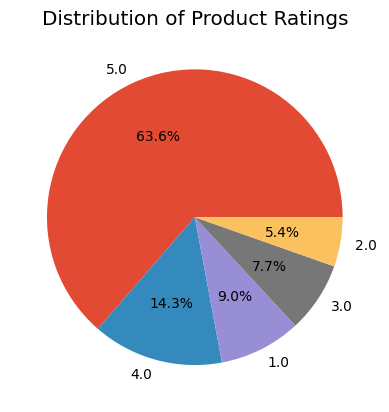

In [9]:
# Rating Distribution Pie Chart
rating_counts = amazon_ratings['Rating'].value_counts()
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Product Ratings')
plt.show()

## Collaborative Filtering Recommendation System

Below we create a recommendation system that uses collaborative filtering to make predictive suggestions for a particular user based on patterns from user data.


In [10]:
# Collaborative Filtering Recommendation System

def collaborative_filtering_recommendation(data, product_id, top_n=10):

    # Creating a utility matrix
    ratings_utility_matrix = data.pivot_table(values='Rating', index='UserId', columns='ProductId', fill_value=0)

    # Transposing the matrix
    X = ratings_utility_matrix.T

    # Decomposing the matrix using SVD
    SVD = TruncatedSVD(n_components=10)
    decomposed_matrix = SVD.fit_transform(X)

    # Creating a correlation matrix
    correlation_matrix = np.corrcoef(decomposed_matrix)

    # Getting the index of the product_id
    product_index = list(X.index).index(product_id)

    # Getting the correlation values with other products
    correlation_with_product = correlation_matrix[product_index]

    # Recommending top-n correlated products
    recommended_products = list(X.index[correlation_with_product > 0.90])

    # Remove the given product_id from the list
    recommended_products.remove(product_id)

    return recommended_products[:top_n]

In [11]:
# Get top 10 product recommendations for product '6117036094'
product_recommendations = collaborative_filtering_recommendation(amazon_ratings.head(10000), '6117036094')
print(product_recommendations)

['7800558258']


In [13]:
# Load product description dataset
product_descriptions = pd.read_csv('./product_descriptions.csv')

In [14]:
# Drop missing values
product_descriptions = product_descriptions.dropna()

# Taking a subset of the data for demonstration
product_subset = product_descriptions.head(500)

# Feature extraction: Convert text descriptions into numerical data
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(product_subset["product_description"])

# Apply K-Means clustering on the processed data
num_clusters = 10
kmeans_model = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=1)
kmeans_model.fit(X)


KMeans(max_iter=100, n_clusters=10, n_init=1)

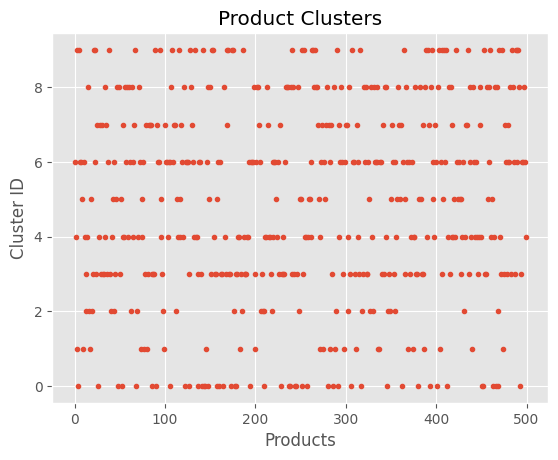

Cluster 0:
water, garage, use, easy, roof, epoxy, sq, seal, shower, proposition, 

Cluster 1:
rug, design, clean, slightly, contemporary, csa, easy, look, vary, stakes, 

Cluster 2:
cabinet, pull, light, nickel, center, design, kit, black, includes, 32, 

Cluster 3:
storage, lbs, steel, shelves, easy, duty, capacity, shelf, adjustable, durable, 

Cluster 4:
wood, door, flush, natural, toilet, bamboo, product, home, water, ft, 

Cluster 5:
base, used, painted, post, primed, moulding, 65, proposition, nbsp, residents, 

Cluster 6:
metal, power, volt, 20, cutting, tool, year, speed, handle, light, 

Cluster 7:
paint, roller, easy, ft, water, brush, need, handle, stake, azek, 

Cluster 8:
wall, piece, color, tile, use, home, finish, design, indoor, outdoor, 

Cluster 9:
air, power, cooking, cooling, oven, cycle, control, heat, water, ft, 



In [15]:
# Visualizing clusters
y_kmeans = kmeans_model.predict(X)
plt.plot(y_kmeans, ".")
plt.title('Product Clusters')
plt.xlabel('Products')
plt.ylabel('Cluster ID')
plt.show()

# Display top terms per cluster
def print_cluster_terms(model, vectorizer, n_words=10):
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()
    for i in range(num_clusters):
        print(f"Cluster {i}:")
        for ind in order_centroids[i, :n_words]:
            print(terms[ind], end=', ')
        print("\n")

print_cluster_terms(kmeans_model, vectorizer)

In [16]:
# Print the top terms per cluster
def print_cluster_terms(cluster_num, vectorizer, model, n_terms=10):
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()
    print("Cluster %d:" % cluster_num)
    for ind in order_centroids[cluster_num, :n_terms]:
        print(' %s' % terms[ind])

# Recommendation function based on key search words
def recommend_products(keyword, model, vectorizer):
    Y = vectorizer.transform([keyword])
    cluster_prediction = model.predict(Y)[0]
    print_cluster_terms(cluster_prediction, vectorizer, model)


In [17]:
# Examples
print("\nRecommendation for 'cutting tool':")
recommend_products("cutting tool", kmeans_model, vectorizer)

print("\nRecommendation for 'spray paint':")
recommend_products("spray paint", kmeans_model, vectorizer)

print("\nRecommendation for 'steel drill':")
recommend_products("steel drill", kmeans_model, vectorizer)

print("\nRecommendation for 'water':")
recommend_products("water", kmeans_model, vectorizer)


Recommendation for 'cutting tool':
Cluster 6:
 metal
 power
 volt
 20
 cutting
 tool
 year
 speed
 handle
 light

Recommendation for 'spray paint':
Cluster 7:
 paint
 roller
 easy
 ft
 water
 brush
 need
 handle
 stake
 azek

Recommendation for 'steel drill':
Cluster 6:
 metal
 power
 volt
 20
 cutting
 tool
 year
 speed
 handle
 light

Recommendation for 'water':
Cluster 0:
 water
 garage
 use
 easy
 roof
 epoxy
 sq
 seal
 shower
 proposition


## Embeddings

In the context of recommendation systems, embedding layers can capture the latent factors associated with users and products, which might influence the ratings. For example, some latent factors for products could be their general popularity or quality. These latent factors are captured by training embeddings within the neural network.

 The model aims to predict these ratings as accurately as possible. This can be used in a recommendation system to suggest products to users based on their past behavior and the behavior of similar users.


In [18]:
# Embeddings

# Assigning unique numeric IDs to users and products
user_ids = amazon_ratings['UserId'].astype('category').cat.codes.values
product_ids = amazon_ratings['ProductId'].astype('category').cat.codes.values

# Number of unique users and products
n_users = amazon_ratings['UserId'].nunique()
n_products = amazon_ratings['ProductId'].nunique()

In [19]:
# Embedding dimensions
embedding_size = 50

# Inputs
user_input = Input(shape=(1,))
product_input = Input(shape=(1,))

# User and Product Embeddings
user_embedding = Embedding(output_dim=embedding_size, input_dim=n_users)(user_input)
product_embedding = Embedding(output_dim=embedding_size, input_dim=n_products)(product_input)

# Merge embeddings
merged = concatenate([user_embedding, product_embedding])
merged = Flatten()(merged)

# Add Dense layers
dense = Dense(128, activation='relu')(merged)
dense = Dense(64, activation='relu')(dense)
output = Dense(1)(dense)

# Model
model = Model(inputs=[user_input, product_input], outputs=output)
model.compile(optimizer='adam', loss='mse')


In [20]:
# Train the model
model.fit([user_ids, product_ids], amazon_ratings['Rating'], epochs=10, batch_size=512, validation_split=0.2)

Epoch 1/10
1448/1448 [==============================] - 22s 11ms/step - loss: 1.9871 - val_loss: 1.6914
Epoch 2/10
1448/1448 [==============================] - 9s 6ms/step - loss: 0.8403 - val_loss: 2.1278
Epoch 3/10
1448/1448 [==============================] - 8s 6ms/step - loss: 0.4784 - val_loss: 2.4758
Epoch 4/10
1448/1448 [==============================] - 9s 6ms/step - loss: 0.2881 - val_loss: 2.6051
Epoch 5/10
1448/1448 [==============================] - 8s 6ms/step - loss: 0.1665 - val_loss: 3.0159
Epoch 6/10
1448/1448 [==============================] - 9s 6ms/step - loss: 0.1170 - val_loss: 2.8095
Epoch 7/10
1448/1448 [==============================] - 8s 6ms/step - loss: 0.0902 - val_loss: 3.1538
Epoch 8/10
1448/1448 [==============================] - 9s 6ms/step - loss: 0.0764 - val_loss: 2.9399
Epoch 9/10
1448/1448 [==============================] - 8s 6ms/step - loss: 0.0665 - val_loss: 3.0219
Epoch 10/10
1448/1448 [==============================] - 9s 6ms/step - loss: 0.0

Epoch 1/10
1448/1448 [==============================] - 8s 6ms/step - loss: 0.0503 - val_loss: 2.9132
Epoch 2/10
1448/1448 [==============================] - 8s 6ms/step - loss: 0.0439 - val_loss: 2.8226
Epoch 3/10
1448/1448 [==============================] - 8s 6ms/step - loss: 0.0386 - val_loss: 2.7976
Epoch 4/10
1448/1448 [==============================] - 8s 6ms/step - loss: 0.0340 - val_loss: 2.6258
Epoch 5/10
1448/1448 [==============================] - 8s 6ms/step - loss: 0.0306 - val_loss: 2.5766
Epoch 6/10
1448/1448 [==============================] - 8s 6ms/step - loss: 0.0269 - val_loss: 2.4450
Epoch 7/10
1448/1448 [==============================] - 8s 6ms/step - loss: 0.0241 - val_loss: 2.4065
Epoch 8/10
1448/1448 [==============================] - 8s 6ms/step - loss: 0.0219 - val_loss: 2.4415
Epoch 9/10
1448/1448 [==============================] - 8s 6ms/step - loss: 0.0199 - val_loss: 2.3936
Epoch 10/10
1448/1448 [==============================] - 8s 6ms/step - loss: 0.018

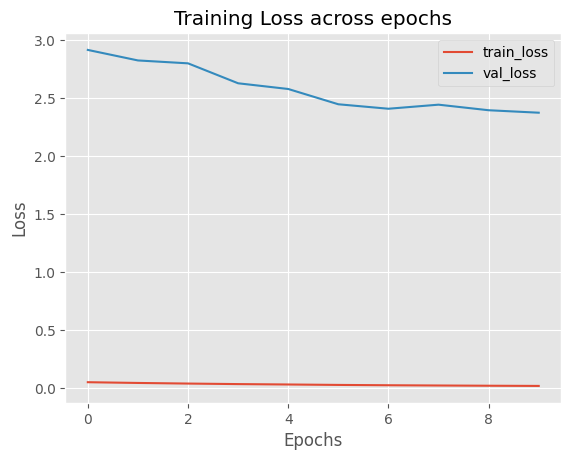

In [21]:
# Plot training history
def plot_training_history(history):
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Training Loss across epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

history = model.fit([user_ids, product_ids], amazon_ratings['Rating'], epochs=10, batch_size=512, validation_split=0.2)
plot_training_history(history)

In [22]:
class RecommenderHyperModel(HyperModel):

    def __init__(self, n_users, n_products):
        self.n_users = n_users
        self.n_products = n_products

    def build(self, hp):
        embedding_size = hp.Int('embedding_size', min_value=10, max_value=200, step=10)

        user_input = Input(shape=(1,))
        product_input = Input(shape=(1,))

        user_embedding = Embedding(output_dim=embedding_size, input_dim=self.n_users)(user_input)
        product_embedding = Embedding(output_dim=embedding_size, input_dim=self.n_products)(product_input)

        merged = concatenate([user_embedding, product_embedding])
        merged = Flatten()(merged)

        # Tuning the number of neurons in the dense layers
        for i in range(hp.Int('num_layers', 1, 4)):
            merged = Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=256, step=32),
                           activation='relu')(merged)

        output = Dense(1)(merged)
        model = Model(inputs=[user_input, product_input], outputs=output)

        # Tuning the learning rate
        learning_rate = hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4, 5e-5])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

        return model

# Initialize the hypermodel
hypermodel = RecommenderHyperModel(n_users, n_products)


In [23]:
# Random search
tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='random_search',
    project_name='recommender'
)

tuner.search_space_summary()

# Start the search
tuner.search([user_ids, product_ids],
             amazon_ratings['Rating'],
             epochs=5,
             validation_split=0.2,
             batch_size=512)


Trial 10 Complete [00h 01m 33s]
val_loss: 1.7093368172645569

Best val_loss So Far: 1.7012302875518799
Total elapsed time: 00h 23m 23s


In [25]:
shutil.rmtree('random_search')

# Retrieve the best model and its performance
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(best_hyperparameters.values)

{'embedding_size': 30, 'num_layers': 3, 'units_0': 256, 'learning_rate': 0.001, 'units_1': 96, 'units_2': 224, 'units_3': 128}


In [26]:
# Build the best model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hyperparameters)

# Train the best model with validation_split
history = best_model.fit(
    [user_ids, product_ids],
    amazon_ratings['Rating'],
    epochs=10,
    batch_size=512,
    validation_split=0.2
)

# Extract the validation loss from the history object
val_loss = history.history['val_loss'][-1]

print(f"Validation loss: {val_loss}")

Epoch 1/10
1448/1448 [==============================] - 16s 9ms/step - loss: 1.8219 - val_loss: 1.7203
Epoch 2/10
1448/1448 [==============================] - 8s 6ms/step - loss: 0.9287 - val_loss: 2.5040
Epoch 3/10
1448/1448 [==============================] - 8s 5ms/step - loss: 0.4746 - val_loss: 3.3406
Epoch 4/10
1448/1448 [==============================] - 8s 5ms/step - loss: 0.2538 - val_loss: 3.2825
Epoch 5/10
1448/1448 [==============================] - 8s 6ms/step - loss: 0.1588 - val_loss: 2.9748
Epoch 6/10
1448/1448 [==============================] - 8s 5ms/step - loss: 0.1029 - val_loss: 3.4357
Epoch 7/10
1448/1448 [==============================] - 8s 6ms/step - loss: 0.0815 - val_loss: 3.0466
Epoch 8/10
1448/1448 [==============================] - 8s 5ms/step - loss: 0.0670 - val_loss: 3.0906
Epoch 9/10
1448/1448 [==============================] - 8s 5ms/step - loss: 0.0571 - val_loss: 3.1534
Epoch 10/10
1448/1448 [==============================] - 8s 5ms/step - loss: 0.04